# Creating a consumer resource model from smetana data
- load and parse the smetana data
- convert the data into a SBML model (with first order reactions)
- simulate the model using tellurium 
- convert into a mira model and simulate the model using pyciemss

### import packages and load data

In [1]:
import pandas as pd
import tellurium as te
import antimony as at
import simplesbml 
import mira
import libsbml
import numpy as np
from mira.sources.sbml import template_model_from_sbml_file
from mira.metamodel import Distribution

import os
import pyciemss
import torch

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
)


/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_42339/2005571738.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
smetana_file = "../data/smetana_results/smetana_results_gurobi_victor_detailed.tsv"
smetana_df = pd.read_csv(smetana_file, sep='\t')
smetana_df

,community,medium,receiver,donor,compound,scs,mus,mps,smetana
0,all,minimal,updated_csc009,updated_csc031,M_arg__L_e,0.333333,0.08,1,0.026667
1,all,minimal,updated_csc009,updated_csc031,M_gua_e,0.333333,0.10,1,0.033333
2,all,minimal,updated_csc009,updated_csc031,M_h2s_e,0.333333,0.33,1,0.110000
3,all,minimal,updated_csc009,updated_csc031,M_hom__L_e,0.333333,0.07,1,0.023333
4,all,minimal,updated_csc009,updated_csc031,M_nh4_e,0.333333,0.09,1,0.030000
...,...,...,...,...,...,...,...,...,...
104,all,minimal,csc043,updated_csc040,M_s_e,1.000000,0.22,1,0.220000
105,all,minimal,csc043,updated_csc052,M_arg__L_e,0.333333,0.22,1,0.073333
106,all,minimal,csc043,updated_csc052,M_h2s_e,0.333333,0.78,1,0.260000
107,all,minimal,csc043,updated_csc052,M_lys__L_e,0.333333,0.46,1,0.153333


### create antimony model using first order reaction kinetics 

for each row of the smetana data:

- donor-to-compound reaction: donor -> compound; rate: k_d*donor

- compound-to-receiver reaction: compound -> receiver; k_r*compound

- use uniform(0,1) initial values for the model variables (donor, compound, receiver)

- k_d = scs and k_r = mus for that row 

In [87]:

seed = 0
np.random.seed(seed)

reaction_list = []
parameter_list = []
initial_values_set = set()


for index, row in smetana_df.iterrows():
    donor_reaction = f'\t{row.donor} -> {row.compound}; k_d{index}*{row.donor}'
    receiver_reaction = f'\t{row.compound} -> {row.receiver}; k_r{index}*{row.compound}'
    reaction_list.extend([donor_reaction,receiver_reaction])
    parameter_list.extend([f'\tk_d{index}={row.scs}',f'\tk_r{index}={row.mus}'])
    initial_values_set.add(row.donor)
    initial_values_set.add(row.compound)
    initial_values_set.add(row.receiver)

initial_values_string = "\n".join([f"\t{name}={np.random.uniform(0,1)}" for name in initial_values_set])
species_names_string = "\n".join([f'\t{species} is "{species}"' for species in initial_values_set])

reaction_string = "\n".join(reaction_list)
parameter_string = "\n".join(parameter_list)

antimony_str = f"""
model smetana
{reaction_string}
{parameter_string}
{initial_values_string}
{species_names_string}
end
"""


antimony_file = 'test_antimony_file.txt'
print(antimony_str)



with open(antimony_file, 'w') as f:
    f.write(antimony_str)


model smetana
	updated_csc031 -> M_arg__L_e; k_d0*updated_csc031
	M_arg__L_e -> updated_csc009; k_r0*M_arg__L_e
	updated_csc031 -> M_gua_e; k_d1*updated_csc031
	M_gua_e -> updated_csc009; k_r1*M_gua_e
	updated_csc031 -> M_h2s_e; k_d2*updated_csc031
	M_h2s_e -> updated_csc009; k_r2*M_h2s_e
	updated_csc031 -> M_hom__L_e; k_d3*updated_csc031
	M_hom__L_e -> updated_csc009; k_r3*M_hom__L_e
	updated_csc031 -> M_nh4_e; k_d4*updated_csc031
	M_nh4_e -> updated_csc009; k_r4*M_nh4_e
	updated_csc031 -> M_orn_e; k_d5*updated_csc031
	M_orn_e -> updated_csc009; k_r5*M_orn_e
	updated_csc040 -> M_4abut_e; k_d6*updated_csc040
	M_4abut_e -> updated_csc009; k_r6*M_4abut_e
	updated_csc040 -> M_arg__L_e; k_d7*updated_csc040
	M_arg__L_e -> updated_csc009; k_r7*M_arg__L_e
	updated_csc040 -> M_asp__L_e; k_d8*updated_csc040
	M_asp__L_e -> updated_csc009; k_r8*M_asp__L_e
	updated_csc040 -> M_fe3_e; k_d9*updated_csc040
	M_fe3_e -> updated_csc009; k_r9*M_fe3_e
	updated_csc040 -> M_fe3pyovd_kt_e; k_d10*updated_csc

### save antimony model as SBML using tellurium and libroadrunner

In [88]:
smbl_file = 'smetana_carbstor_consumer_resource.xml'
rr_model = te.loada(antimony_file)
rr_model.exportToSBML(smbl_file)



### simulate SBML model

In [90]:
# simulate and plot
# rr_model.simulate(0, 500, 500)
# rr_model.plot()
# rr_model.resetToOrigin()

### Update SBML species name, initial concentration, and has_only_substance_units fields

the exported file from tellurium does not have the species names, concentrations, and has_only_substance_units correctly set to use with MIRA and PYCIEMSS 

TODO: fix this ^^

In [91]:
corrected_smbl_file = 'smetana_carbstor_consumer_resource_corrected.xml'

d = libsbml.readSBMLFromFile(smbl_file)
m = d.getModel()
# for initial in m.getListOfInitialAssignments():
#     print(initial)

for species in m.getListOfSpecies():
    species.name = species.id
    species.initial_concentration = species.initial_amount
    species.has_only_substance_units = False

libsbml.writeSBMLToFile(d,corrected_smbl_file)

1

### load SBML into MIRA

see: https://github.com/gyorilab/mira/tree/main and https://miramodel.readthedocs.io/en/latest/

In [92]:
smetana_model = template_model_from_sbml_file(corrected_smbl_file)

smetana_model.initials


{'updated_csc031': Initial(concept=Concept(name='updated_csc031', display_name='updated_csc031', description=None, identifiers={}, context={}, units=None), expression=0.143353287409046),
 'M_arg__L_e': Initial(concept=Concept(name='M_arg__L_e', display_name='M_arg__L_e', description=None, identifiers={}, context={}, units=None), expression=0.645894113066656),
 'updated_csc009': Initial(concept=Concept(name='updated_csc009', display_name='updated_csc009', description=None, identifiers={}, context={}, units=None), expression=0.602763376071644),
 'M_gua_e': Initial(concept=Concept(name='M_gua_e', display_name='M_gua_e', description=None, identifiers={}, context={}, units=None), expression=0.548813503927325),
 'M_h2s_e': Initial(concept=Concept(name='M_h2s_e', display_name='M_h2s_e', description=None, identifiers={}, context={}, units=None), expression=0.774233689434217),
 'M_hom__L_e': Initial(concept=Concept(name='M_hom__L_e', display_name='M_hom__L_e', description=None, identifiers={}, 

### assign priors in mira model (optional)

compartment is considered a parameter in this model but it does not get a prior (for now)

In [93]:
## for priors

from mira.metamodel import Distribution


dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 0.0,"maximum": 1.0 }     
                     )

for name,parameter in smetana_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = dist
    print(name,parameter, parameter.distribution)

parameter

k_d0 name='k_d0' display_name=None description='' identifiers={} context={} units=None value=0.333333333333333 distribution=Distribution(type='Uniform1', parameters={'minimum': 0.0, 'maximum': 1.0}) type='Uniform1' parameters={'minimum': 0.0, 'maximum': 1.0}
k_r0 name='k_r0' display_name=None description='' identifiers={} context={} units=None value=0.08 distribution=Distribution(type='Uniform1', parameters={'minimum': 0.0, 'maximum': 1.0}) type='Uniform1' parameters={'minimum': 0.0, 'maximum': 1.0}
k_d1 name='k_d1' display_name=None description='' identifiers={} context={} units=None value=0.333333333333333 distribution=Distribution(type='Uniform1', parameters={'minimum': 0.0, 'maximum': 1.0}) type='Uniform1' parameters={'minimum': 0.0, 'maximum': 1.0}
k_r1 name='k_r1' display_name=None description='' identifiers={} context={} units=None value=0.1 distribution=Distribution(type='Uniform1', parameters={'minimum': 0.0, 'maximum': 1.0}) type='Uniform1' parameters={'minimum': 0.0, 'maximu

Parameter(name='default_compartment', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None)

### simulate the model in pyCIEMSS (specify initial conditions)

see: https://github.com/ciemss/pyciemss/blob/main/docs/source/interfaces.ipynb

first set the simulation parameters

In [94]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 1.0
num_samples = 1


In [95]:
result1 = pyciemss.sample(smetana_model, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())
print(result1.keys())

KeyboardInterrupt: 

### plot results

these should be the same as the tellurium simulation (without using priors) 

In [ ]:
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Model calibration

- simulate 4 datasets in tellurium using the same SBML model (i.e., reactions, parameters and initial conditions): 
  1. all observables, 6 time points, should reach steady state, no noise
  2. all observables, 12 time points, should reach steady state, no noise
  3. donor and receiver (no metabolites), 6 time points, should reach steady state, no noise
  4.  donor and receiver (no metabolites), 12 time points, should reach steady state, no noise
- for each of the 4 datasets calibrate the model using pyciemss
- evaluate the quality of calibration and information gained for 6 vs 12 time points, all observables vs no metabolites

### simulating data

In [97]:
smetana_carbstor_sbml_file = './smetana_carbstor_consumer_resource_corrected.xml'
rr_model = te.loadSBMLModel(smetana_carbstor_sbml_file)

all_species = rr_model.getFloatingSpeciesIds()
species_wo_metabolites = [s for s in all_species if not s.startswith('M')]

print(f'The model contains {len(species_wo_metabolites)} donor and receiver species and {len(all_species)-len(species_wo_metabolites)} metabolite compounds.')


The model contains 5 donor and receiver species and 27 metabolite compounds.


In [ ]:
def create_custom_time_vector(num_points_initial, num_points_steady, t_initial_end=100, t_total_end=500):
    """Create a custom time vector with specified number of points"""
    initial_phase = np.linspace(0, t_initial_end, num_points_initial, endpoint=False)
    steady_phase = np.linspace(t_initial_end, t_total_end, num_points_steady)
    time_vector = np.concatenate((initial_phase, steady_phase))
    return time_vector


time_points_6 = create_custom_time_vector(3, 3, 50, 500)
time_points_12 = create_custom_time_vector(6, 6, 50, 500)
time_points_9 = create_custom_time_vector(6, 3, 50, 500)

print(f"Time vector with 6 points: {time_points_6}")
print(f"Time vector with 12 points: {time_points_12}")
print(f"Time vector with 12 points: {time_points_9}")

In [ ]:

# simulate and plot
results1 = rr_model.simulate(times=time_points_6)
rr_model.plot(title='6 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

results2 = rr_model.simulate(times=time_points_12)
rr_model.plot(title='12 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

results3 = rr_model.simulate(times=time_points_9)
rr_model.plot(title='9 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

In [ ]:

def format_and_save_road_runner_results(fname, rr_results, obs_mets=True):
    formatted_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
    if not obs_mets:
        formatted_df = formatted_df.loc[:, ~formatted_df.columns.str.startswith('[M')]
    formatted_df = formatted_df.set_index('time')
    formatted_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss
    formatted_df.to_csv(fname)
    return formatted_df

In [ ]:
# all observations (incl. metabolites), 6 time points
all_obs_6_measurements_data_file_path = 'simulated_data_w_mets_6_measurements.csv'
all_obs_6_measurements = format_and_save_road_runner_results(all_obs_6_measurements_data_file_path,results1, obs_mets=True )
all_obs_6_measurements.head()

In [ ]:
# no metabolite observations, 6 time points
no_mets_6_measurements_data_file_path = 'simulated_data_no_mets_6_measurements.csv'
no_mets_6_measurements = format_and_save_road_runner_results(no_mets_6_measurements_data_file_path, results1, obs_mets=False)
no_mets_6_measurements.head()


In [ ]:
# all observations (incl. metabolites), 12 time points
all_obs_12_measurements_data_file_path = 'simulated_data_w_mets_12_measurements.csv'
all_obs_12_measurements = format_and_save_road_runner_results(all_obs_12_measurements_data_file_path, results2, obs_mets=True)
all_obs_12_measurements.head()

In [ ]:
# no metabolite observations, 12 time points
no_mets_12_measurements_data_file_path = 'simulated_data_no_mets_12_measurements.csv'
no_mets_12_measurements = format_and_save_road_runner_results(no_mets_12_measurements_data_file_path, results2, obs_mets=False)
no_mets_12_measurements.head()

In [ ]:
# all observations (incl. metabolites), 9 time points
all_obs_9_measurements_data_file_path = 'simulated_data_w_mets_9_measurements.csv'
all_obs_9_measurements = format_and_save_road_runner_results(all_obs_9_measurements_data_file_path,results3, obs_mets=True )
all_obs_9_measurements.head()

In [ ]:
# no metabolites measured, 9 time points
no_mets_9_measurements_data_file_path = 'simulated_data_no_mets_9_measurements.csv'
no_mets_9_measurements = format_and_save_road_runner_results(no_mets_9_measurements_data_file_path,results3, obs_mets=False )
no_mets_9_measurements.head()

### calibration

- assign priors (if needed)
- save as AMRPetriNet (JSON) file
- run calibration

In [98]:
smetana_carbstor_mira_model = template_model_from_sbml_file(smetana_carbstor_sbml_file)

## for priors use uniform(0,1)

from mira.metamodel import Distribution


dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 0.0,"maximum": 1.0 }     
                     )

for name,parameter in smetana_carbstor_mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = dist

parameter

Parameter(name='default_compartment', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None)

In [99]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model

model_json_file_name = 'smetana_carbstor_mira_model_w_priors.json'
 
pm = AMRPetriNetModel(Model(smetana_carbstor_mira_model))
pm.to_json_file(
            model_json_file_name,
            name='smetana_carbstor_mira_model_w_priors',
            description="smetana_carbstor_mira_model_w_priors",
            indent=2,
        )



In [ ]:
num_iterations = 100
data_to_use = no_mets_9_measurements
data_path = no_mets_9_measurements_data_file_path
model_path_or_json = model_json_file_name

data_mapping = {k:k.strip("[]") for k in data_to_use.columns}  # remove '[]' for concentration added by Tellurium
calibration_results = pyciemss.calibrate(model_path_or_json, data_path, data_mapping=data_mapping, num_iterations=num_iterations, verbose=True)

In [ ]:
calibration_results

In [ ]:
parameter_estimates = calibration_results["inferred_parameters"]
parameter_estimates()

In [ ]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 1	#1.0
num_samples = 100

calibrated_sample_results = pyciemss.sample(smetana_carbstor_mira_model, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())


In [ ]:
calibrated_sample_results.keys()
calibrated_sample_results['unprocessed_result'].keys()

In [ ]:
# Plot results for all states
schema = plots.trajectories(calibrated_sample_results["data"], keep=".*_state")
#plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# get ground truths (for simulated data)
import json
# Load the JSON file
with open(model_path_or_json, 'r') as f:
    json_data = json.load(f)

# Extract the parameter ground truth values
parameters_info = json_data['semantics']['ode']['parameters']
ground_truth = {param['id']: param['value'] for param in parameters_info}

# Function to clean parameter names by removing "persistent_" prefix
def clean_param_name(param_name):
    return param_name.replace("persistent_", "")

ground_truth

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math


# Extract the unprocessed results (parameter estimates)
unprocessed_result = calibrated_sample_results['unprocessed_result']

# Isolate only 1-dimensional tensors (parameters) and clean parameter names
parameters_data = {clean_param_name(k): v.numpy() for k, v in unprocessed_result.items() if v.ndim == 1}

if not parameters_data:
    print("No parameters found in the unprocessed results.")
else:
    # Convert to Pandas DataFrame
    parameters_df = pd.DataFrame(parameters_data)
    
    if parameters_df.empty:
        print("The parameters DataFrame is empty.")
    else:
        # Plotting in multiple subplots to avoid overcrowding
        num_parameters = len(parameters_df.columns)
        num_rows = math.ceil(num_parameters / 5)  # Adjust the number of columns per row
        fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, num_rows * 5), sharex=True)
        
        # Flatten the axes for easy indexing
        axes = axes.flatten()
        
        for i, column in enumerate(parameters_df.columns):
            sns.kdeplot(parameters_df[column], ax=axes[i], fill=True)
            # Plotting the ground truth value as a vertical line
            if column in ground_truth:
                axes[i].axvline(ground_truth[column], color='red', linestyle='--', label=f'Ground Truth: {ground_truth[column]}')
                axes[i].legend()
            axes[i].set_title(column)
        
        # Hide any unused subplots
        for i in range(num_parameters, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()



In [ ]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 1	#1.0
num_samples = 100

prior_predictive_sample_results = pyciemss.sample(smetana_carbstor_mira_model, end_time, logging_step_size, num_samples, 
                start_time=start_time)
display(prior_predictive_sample_results["data"].head())

In [ ]:
# Plot results for all states
schema = plots.trajectories(prior_predictive_sample_results["data"], keep=".*_state")
#plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)




# model for calcium carbonate ($\mathrm{CaCO_3}$) precipitation
ref: https://www.mdpi.com/2076-3417/14/7/2854 (eqns 1-6)



see also: https://pubmed.ncbi.nlm.nih.gov/1857197/, https://pubmed.ncbi.nlm.nih.gov/1857197/ (for enzymatic reactions)



## Calculation of Molarity of Calcium in Solution

### Problem Statement:
To find the molarity (mol/L) of calcium in a solution where 20 grams of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ is dissolved in 1 liter of water.

### Step-by-Step Calculation:

1. **Molar Mass of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$**:
   - Calculate the molar mass of calcium chloride dihydrate:
     - Calcium (Ca): $1 \times 40.08 \, \text{g/mol} = 40.08 \, \text{g/mol}$
     - Chlorine (Cl): $2 \times 35.45 \, \text{g/mol} = 70.90 \, \text{g/mol}$
     - Water (H₂O): $2 \times 18.02 \, \text{g/mol} = 36.04 \, \text{g/mol}$
     - Total molar mass: $40.08 + 70.90 + 36.04 = 147.02 \, \text{g/mol}$

2. **Convert Grams to Moles**:
   - Use the molar mass to convert the mass of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ to moles:
     $$
     \text{moles of } \text{CaCl}_2 \cdot 2\text{H}_2\text{O} = \frac{20 \, \text{g}}{147.02 \, \text{g/mol}} \approx 0.136 \, \text{mol}
     $$

3. **Determine Molarity of Calcium**:
   - Since the solution volume is 1 liter, the molarity of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ is:
     $$
     \text{Molarity of } \text{CaCl}_2 \cdot 2\text{H}_2\text{O} = \frac{0.136 \, \text{mol}}{1 \, \text{L}} = 0.136 \, \text{M}
     $$

4. **Calcium Ion Contribution**:
   - Each formula unit of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ dissociates to give 1 calcium ion ($\text{Ca}^{2+}$) and 2 chloride ions ($\text{Cl}^-$) in solution.
   - Therefore, the molarity of calcium ions ($\text{Ca}^{2+}$) is the same as the molarity of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$:
     $$
     \text{Molarity of } \text{Ca}^{2+} = 0.136 \, \text{M}
     $$

### Conclusion:

The molarity of calcium ($\text{Ca}^{2+}$) in the solution is $0.136 \, \text{M}$.



2% CaCl2-2H2O	20 g

## Calculation of Molarity of Urea in Solution

### Problem Statement:
To find the molarity (mol/L) of urea ($\text{CO(NH}_2\text{)}_2$) in a solution where 20 grams of urea is dissolved in 1 liter of water.

### Step-by-Step Calculation:

1. **Molar Mass of Urea**:
   - Calculate the molar mass of urea:
     - Carbon (C): $1 \times 12.01 \, \text{g/mol} = 12.01 \, \text{g/mol}$
     - Oxygen (O): $1 \times 16.00 \, \text{g/mol} = 16.00 \, \text{g/mol}$
     - Nitrogen (N): $2 \times 14.01 \, \text{g/mol} = 28.02 \, \text{g/mol}$
     - Hydrogen (H): $4 \times 1.01 \, \text{g/mol} = 4.04 \, \text{g/mol}$
     - Total molar mass: $12.01 + 16.00 + 28.02 + 4.04 = 60.07 \, \text{g/mol}$

2. **Convert Grams to Moles**:
   - Use the molar mass to convert the mass of urea to moles:
     $$
     \text{moles of urea} = \frac{20 \, \text{g}}{60.07 \, \text{g/mol}} \approx 0.333 \, \text{mol}
     $$

3. **Determine Molarity**:
   - Since the solution volume is 1 liter, the molarity of urea is:
     $$
     \text{Molarity of urea} = \frac{0.333 \, \text{mol}}{1 \, \text{L}} = 0.333 \, \text{M}
     $$

### Conclusion:

The molarity of urea ($\text{CO(NH}_2\text{)}_2$) in the solution is $0.333 \, \text{M}$.

## Calculation of Atmospheric Carbon Dioxide Concentration in Moles per Liter

### Problem Statement:
To find the concentration of atmospheric carbon dioxide ($\text{CO}_2$) in moles per liter (molarity).

### Step-by-Step Calculation:

1. **Partial Pressure of $\text{CO}_2$**:
   - Atmospheric $\text{CO}_2$ concentration is typically around 400 parts per million (ppm).
   - This means that $\text{CO}_2$ constitutes $0.04\%$ of the total atmospheric pressure.
   - Assuming standard atmospheric pressure is 1 atmosphere (atm), the partial pressure of $\text{CO}_2$ is:
     $$
     P_{\text{CO}_2} = 0.04\% \times 1 \, \text{atm} = 0.0004 \, \text{atm}
     $$

2. **Ideal Gas Law**:
   - The ideal gas law is given by:
     $$
     PV = nRT
     $$
   - Where:
     - $P$ = pressure in atm
     - $V$ = volume in liters
     - $n$ = number of moles
     - $R$ = ideal gas constant $= 0.0821 \, \text{L} \cdot \text{atm}/(K\cdot mol)$
     - $T$ = temperature in Kelvin (K)
   - Rearranging to solve for molarity (moles per liter):
     $$
     \frac{n}{V} = \frac{P}{RT}
     $$

3. **Assumptions**:
   - Standard temperature $T = 298 \, \text{K}$ (25°C)

4. **Calculation**:
   - Using the values:
     $$
     P_{\text{CO}_2} = 0.0004 \, \text{atm}
     $$
     $$
     R = 0.0821 \, \text{L} \cdot \text{atm}/(K\cdot mol)
     $$
     $$
     T = 298 \, \text{K}
     $$
   - Plugging in these values:
     $$
     \frac{n}{V} = \frac{0.0004 \, \text{atm}}{0.0821 \, \text{L} \cdot \text{atm}/(K\cdot mol)} \times 298 \, \text{K}
     $$
     $$
     \frac{n}{V} = \frac{0.0004}{24.45} \, \text{mol/L}
     $$
     $$
     \frac{n}{V} \approx 1.64 \times 10^{-5} \, \text{mol/L}
     $$

### Conclusion:

The concentration of atmospheric carbon dioxide is approximately $1.64 \times 10^{-5}$ moles per liter (M).
 

<!-- # model for calcium carbonate ($\mathrm{CaCO_3}$) precipitation

see: https://www.frontiersin.org/journals/materials/articles/10.3389/fmats.2019.00126/full (eqns 1-7 and figure 4)

$$\begin{array}{rcl}
 \text{CO(NH}_2\text{)}_2 + \text{H}_2 &\rightarrow& \text{NH}_2\text{COOH} + \text{NH}_3  \\
 \text{NH}_2\text{COOH} + \text{H}_2\text{O} &\rightarrow& \text{NH}_3 + \text{H}_2\text{CO}_3  \\
 \text{H}_2\text{CO}_3 &\leftrightarrow& \text{HCO}_3^- + \text{H}^+  \\
 \text{NH}_3 + 2\text{H}_2\text{O} &\rightarrow& 2\text{NH}_4^+ + 2\text{OH}^-  \\
 \text{HCO}_3^- + \text{H}^+ + 2\text{NH}_4^+ + 2\text{OH}^- &\rightarrow& \text{CO}_2^- + 2\text{NH}_4^+ + 2\text{H}_2\text{O}  \\
 \text{Ca}^{2+} + \text{Cell} &\rightarrow& \text{Cell}-\text{Ca}^{2+}  \\
 \text{Cell}-\text{Ca}^{2+} + \text{CO}_3^{2-} &\rightarrow& \text{Cell}-\text{CaCO}_3 
\end{array}$$
 
 note: pH + pOH = 14, so we should enforce that constraint on the model -->

<!-- | Organism               | Enzymes and Genes                 | Pathways             |
|------------------------|-----------------------------------|----------------------|
| _B. strain_            | Not present                       |                      |
| _Curtobacterium strain_| Not present                       |                      |
| _Microbacterium_       | Not present                       |                      |
| _Paenibacillus strain_ | Urease: ureC, ureA                | urea degradation II  |
| _R. strain_            | Urease: ureC_2, ureB_2, ureA2     | urea degradation II  |
|                        | Urease: ureC_1, ureB_1, ureA      |                      |



| Organism               | Enzymes and Genes                      | Pathways            |
|------------------------|----------------------------------------|---------------------|
| _B. strain_            | Carbonic anhydrase: cah                | cyanate degradation |
| _Curtobacterium strain_| Carbonic anhydrase: cynT               | None                |
| _Microbacterium_       | Carbonic anhydrase: LFNDFJ_06995       | None                |
| _Paenibacillus strain_ | Not present                            |                     |
| _R. strain_            | Carbonic anhydrase: cynT               | None                |
|                        | Beta-carbonic anhydrase 1: mtcA1       |                     | -->


In [100]:
# antimony_model_str = """
# model main

#   // Reaction 1: Urea + Hydrogen -> Carbamic Acid + Ammonia 
#   // driven by urease (EC 3.5.1.5) enzyme
#   J1: urea + hydrogen => carbamic_acid + ammonia; k1*urea*hydrogen;
 

#   // Reaction 2: Carbamic Acid + Water -> Ammonia + Carbonic Acid
#   // driven by carbonic anhydrase (EC 4.2.1.1) enzyme
#   J2: carbamic_acid + water => ammonia + carbonic_acid; k2*carbamic_acid*water;

#   // Reaction 3: Carbonic Acid <-> Bicarbonate + Proton
#   J3: carbonic_acid -> bicarbonate + proton; k3f*carbonic_acid - k3r*bicarbonate*proton;
#   // carbonic anhydrase (CA) 

#   // Reaction 4: Ammonia + Water -> Ammonium + Hydroxide
#   //J4: ammonia + 2 water => 2 ammonium + 2 hydroxide; k4*ammonia*water*water;
#   J4: ammonia + 2 water => 2 ammonium; k4*ammonia*water*water;
  
#   // Reaction 5: Bicarbonate + Proton + Ammonium + Hydroxide -> Carbonate + Ammonium + Water
#   //J5: bicarbonate + proton + 2 ammonium + 2 hydroxide => carbonate + 2 ammonium + 2 water; k5*bicarbonate*proton*ammonium*ammonium*hydroxide*hydroxide;
#   J5: bicarbonate + proton + 2 ammonium  => carbonate + 2 ammonium + 2 water; k5*bicarbonate*proton*ammonium*ammonium*hydroxide*hydroxide;
  
#   // Reaction 6: Calcium Ion + Cell -> Cell-Bound Calcium
#   J6: calcium_ion + cell => cell_bound_calcium; k6*calcium_ion*cell;

#   // Reaction 7: Cell-Bound Calcium + Carbonate -> Cell-Bound Calcium Carbonate
#   J7: cell_bound_calcium + carbonate => cell_bound_calcium_carbonate; k7*cell_bound_calcium*carbonate;

#   // Set initial concentrations for species
#   urea = 1e-3;         // Initial concentration for urea
#   hydrogen = 1e-3;     // Initial concentration for hydrogen
#   carbamic_acid = 0; // Initial concentration for carbamic acid
#   ammonia = 0;      // Initial concentration for ammonia
#   water = 55;        // Initial concentration for water
#   carbonic_acid = 0; // Initial concentration for carbonic acid
#   bicarbonate = 0;  // Initial concentration for bicarbonate
#   proton = 1e-7;       // Initial concentration for proton
#   ammonium = 0;     // Initial concentration for ammonium
#   hydroxide := 10^(-14-log10(proton));    // Initial concentration for hydroxide
#   carbonate = 0;    // Initial concentration for carbonate
#   calcium_ion = 0;  // Initial concentration for calcium ion
#   cell = 1e-3;         // Initial concentration for cell
#   cell_bound_calcium = 0; // Initial concentration for cell-bound calcium
#   cell_bound_calcium_carbonate = 0; // Initial concentration for cell-bound calcium carbonate


#   // Define rate constants
#   k1 = 1; // Rate constant for reaction 1
#   k2 = 1; // Rate constant for reaction 2
#   k3f = 1; // Forward rate constant for reaction 3
#   k3r = 1; // Reverse rate constant for reaction 3
#   k4 = 1; // Rate constant for reaction 4
#   k5 = 1; // Rate constant for reaction 5
#   k6 = 1; // Rate constant for reaction 6
#   k7 = 1; // Rate constant for reaction 7

# end
# """

# antimony_model_str = """
# model MICP

#   const water;

#   // Reaction 1: Ureolysis
#   reaction_ureolysis: urea + water => 2 ammonia + carbon_dioxide; rate_ureolysis;

#   // Reaction 2: Protonation of Ammonia
#   reaction_protonation_NH3: 2 ammonia + 2 water -> 2 ammonium + 2 hydroxide; rate_protonation_NH3;

#   // Reaction 3: CO2 Hydrolysis
#   reaction_CO2_hydrolysis: carbon_dioxide + water -> carbonic_acid; rate_CO2_hydrolysis;

#   // Reaction 4: Dissociation of Carbonic Acid
#   reaction_dissociation_H2CO3: carbonic_acid + hydroxide -> bicarbonate + water; rate_dissociation_H2CO3;

#   // Reaction 5: Dissociation of Bicarbonate
#   reaction_dissociation_HCO3: bicarbonate + hydroxide -> carbonate + water; rate_dissociation_HCO3;

#   // Reaction 6: CaCO3 Precipitation/Dissolution
#   reaction_CaCO3_precipitation: carbonate + calcium_ion -> calcium_carbonate; rate_CaCO3_precipitation;

#   // Set initial concentrations for species
#   urea = 0.33;                      // Initial concentration for urea
#   water = 55;                       // Initial concentration for water
#   ammonia = 1e-5;                      // Initial concentration for ammonia
#   carbon_dioxide = 1e-5;               // Initial concentration for carbon dioxide (from atmosphere)
#   ammonium = 1e-5;                     // Initial concentration for ammonium
#   hydroxide = 1e-7; // Initial concentration for hydroxide
#   carbonic_acid = 1e-5;                // Initial concentration for carbonic acid
#   bicarbonate = 1e-5;                  // Initial concentration for bicarbonate
#   carbonate = 1e-5;                    // Initial concentration for carbonate
#   calcium_ion = 0.136;                  // Initial concentration for calcium ion
#   calcium_carbonate = 0;            // Initial concentration for calcium carbonate

#   // Define rate constants
#   k1f = 1;  // Rate constant for reaction 1 forward
#   k2f = 1;  // Rate constant for reaction 2 forward
#   k2r = 1;  // Rate constant for reaction 2 reverse
#   k3f = 1;  // Rate constant for reaction 3 forward
#   k3r = 1;  // Rate constant for reaction 3 reverse
#   k4f = 1;  // Rate constant for reaction 4 forward
#   k4r = 1;  // Rate constant for reaction 4 reverse  
#   k5f = 1;  // Rate constant for reaction 5 forward
#   k5r = 1;  // Rate constant for reaction 5 reverse 
#   k6f = 1;  // Rate constant for reaction 6 forward
#   k6r = 1;  // Rate constant for reaction 6 reverse

#   // enyzematic reaction parameters
#   V_max_urease = 1.8e4; // M/L/s (1100 mM/mg / min)
#   K_cat_urease = 1;
#   K_m_urease= 0.3; // M (300 mM)
#   urease_conc = 5e-5; // M/L (50 uM)
  

#   V_max_CA = 1.8e6;
#   K_cat_CA = 530000; // 1/s;
#   CA_conc = 3e-5; // M/L (30 uM)
#   K_m_CA = 12.9; // M (12900 mM) 


#   // Define rate laws
#   rate_ureolysis = (V_max_urease*urea*water)/(K_m_urease + urea*water);  // Michaelis-Menton
#   rate_protonation_NH3 = k2f * ammonia * water - k2r * ammonium * hydroxide;
#   rate_CO2_hydrolysis = (K_cat_CA*CA_conc*carbon_dioxide*water)/(K_m_CA + carbon_dioxide*water);   // Michaelis-Menton
#   rate_dissociation_H2CO3 = k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;
#   rate_dissociation_HCO3 = k5f * bicarbonate * hydroxide - k5r * carbonate * water;
#   rate_CaCO3_precipitation = k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

# end
# """


# antimony_model_str = """
# model MICP

#   const water;

#   // Reaction 1: Ureolysis
#   reaction_ureolysis: urea + $water => 2 ammonia + carbon_dioxide; rate_ureolysis;

#   // Reaction 2: Protonation of Ammonia
#   reaction_protonation_NH3: 2 ammonia + 2 water -> 2 ammonium + 2 hydroxide; rate_protonation_NH3;

#   // Reaction 3: CO2 Hydrolysis
#   reaction_CO2_hydrolysis: carbon_dioxide + water -> carbonic_acid; rate_CO2_hydrolysis;

#   // Reaction 4: Dissociation of Carbonic Acid
#   reaction_dissociation_H2CO3: carbonic_acid + hydroxide -> bicarbonate + water; rate_dissociation_H2CO3;

#   // Reaction 5: Dissociation of Bicarbonate
#   reaction_dissociation_HCO3: bicarbonate + hydroxide -> carbonate + water; rate_dissociation_HCO3;

#   // Reaction 6: CaCO3 Precipitation/Dissolution
#   reaction_CaCO3_precipitation: carbonate + calcium_ion -> calcium_carbonate; rate_CaCO3_precipitation;

#   // Set initial concentrations for species
#   urea = 0.33;                      // Initial concentration for urea
#   water = 55;                       // Initial concentration for water
#   ammonia = 1e-5;                      // Initial concentration for ammonia
#   carbon_dioxide = 1e-5;               // Initial concentration for carbon dioxide (from atmosphere)
#   ammonium = 1e-5;                     // Initial concentration for ammonium
#   hydroxide = 1e-7; // Initial concentration for hydroxide
#   carbonic_acid = 1e-5;                // Initial concentration for carbonic acid
#   bicarbonate = 1e-5;                  // Initial concentration for bicarbonate
#   carbonate = 1e-5;                    // Initial concentration for carbonate
#   calcium_ion = 0.136;                  // Initial concentration for calcium ion
#   calcium_carbonate = 0;            // Initial concentration for calcium carbonate

#   // Define rate constants
#   //k1f = 1;  // Rate constant for reaction 1 forward
#   //k1r = 1;  // Rate constant for reaction 1 reverse

#   k2f = 1;  // Rate constant for reaction 2 forward
#   k2r = 1;  // Rate constant for reaction 2 reverse

#   //k3f = 1;  // Rate constant for reaction 3 forward
#   //k3r = 1;  // Rate constant for reaction 3 reverse
  
#   k4f = 1;  // Rate constant for reaction 4 forward
#   k4r = 1;  // Rate constant for reaction 4 reverse  
#   k5f = 1;  // Rate constant for reaction 5 forward
#   k5r = 1;  // Rate constant for reaction 5 reverse 
#   k6f = 1;  // Rate constant for reaction 6 forward
#   k6r = 1;  // Rate constant for reaction 6 reverse

#   // enyzematic reaction parameters
#   V_max_urease = 1.8e4; // M/L/s (1100 mM/mg / min)
#   K_cat_urease = 1;
#   K_m_urease= 0.3; // M (300 mM)
#   urease_conc = 5e-5; // M/L (50 uM)
  

#   V_max_CA = 1.8e6;
#   K_cat_CA = 530000; // 1/s;
#   CA_conc = 3e-5; // M/L (30 uM)
#   K_m_CA = 12.9; // M (12900 mM) 


#   // Define rate laws
#   rate_ureolysis :=  (V_max_urease*urea*water)/(K_m_urease + (urea*water));  // Michaelis-Menton

#   rate_protonation_NH3 := k2f * ammonia * water - k2r * ammonium * hydroxide;

#   rate_CO2_hydrolysis := (K_cat_CA*CA_conc*carbon_dioxide*water)/(K_m_CA + (carbon_dioxide*water));   // Michaelis-Menton
  
#   rate_dissociation_H2CO3 := k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;
#   rate_dissociation_HCO3 := k5f * bicarbonate * hydroxide - k5r * carbonate * water;
#   rate_CaCO3_precipitation := k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

# end
# """

antimony_model_str = """
model MICP

  const water;

  // Reaction 1: Ureolysis
  reaction_ureolysis: urea + $water => 2 ammonia + carbon_dioxide; (V_max_urease*urea)/(K_m_urease + urea);  // Michaelis-Menton (water in excess and fixed);

  // Reaction 2: Protonation of Ammonia
  reaction_protonation_NH3: 2 ammonia + 2 water -> 2 ammonium + 2 hydroxide; k2f * ammonia^2 * water^2 - k2r * ammonium^2 * hydroxide^2;

  // Reaction 3: CO2 Hydrolysis
  reaction_CO2_hydrolysis: carbon_dioxide + water -> carbonic_acid; (K_cat_CA*CA_conc*carbon_dioxide)/(K_m_CA + carbon_dioxide);   // Michaelis-Menton;

  // Reaction 4: Dissociation of Carbonic Acid
  reaction_dissociation_H2CO3: carbonic_acid + hydroxide -> bicarbonate + water; k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;

  // Reaction 5: Dissociation of Bicarbonate
  reaction_dissociation_HCO3: bicarbonate + hydroxide -> carbonate + water; k5f * bicarbonate * hydroxide - k5r * carbonate * water;

  // Reaction 6: CaCO3 Precipitation/Dissolution
  reaction_CaCO3_precipitation: carbonate + calcium_ion -> calcium_carbonate; k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

  // Set initial concentrations for species
  urea = 0.33;                      // Initial concentration for urea
  water = 55;                       // Initial concentration for water
  ammonia = 1e-5;                      // Initial concentration for ammonia
  carbon_dioxide = 1e-5;               // Initial concentration for carbon dioxide (from atmosphere)
  ammonium = 1e-5;                     // Initial concentration for ammonium
  hydroxide = 1e-7; // Initial concentration for hydroxide
  carbonic_acid = 1e-5;                // Initial concentration for carbonic acid
  bicarbonate = 1e-5;                  // Initial concentration for bicarbonate
  carbonate = 1e-5;                    // Initial concentration for carbonate
  calcium_ion = 0.136;                  // Initial concentration for calcium ion
  calcium_carbonate = 0;            // Initial concentration for calcium carbonate

  // Define rate constants
  k2f = 1;  // Rate constant for reaction 2 forward
  k2r = 1;  // Rate constant for reaction 2 reverse
  k4f = 1;  // Rate constant for reaction 4 forward
  k4r = 1;  // Rate constant for reaction 4 reverse  
  k5f = 1;  // Rate constant for reaction 5 forward
  k5r = 1;  // Rate constant for reaction 5 reverse 
  k6f = 1;  // Rate constant for reaction 6 forward
  k6r = 1;  // Rate constant for reaction 6 reverse

  // enyzematic reaction parameters
  V_max_urease = 1.8e4; // M/L/s (1100 mM/mg / min)
  K_m_urease= 0.3; // M (300 mM)
  K_cat_CA = 530000; // 1/s;
  CA_conc = 3e-5; // M/L (30 uM)
  K_m_CA = 12.9; // M (12900 mM) 

  //K_cat_urease = 1;
  //urease_conc = 5e-5; // M/L (50 uM)
  //V_max_CA = 1.8e6;

  // Define rate laws
  //rate_ureolysis :=  (V_max_urease*urea*water)/(K_m_urease + (urea*water));  // Michaelis-Menton
  //rate_protonation_NH3 := k2f * ammonia * water - k2r * ammonium * hydroxide;
  //rate_CO2_hydrolysis := (K_cat_CA*CA_conc*carbon_dioxide*water)/(K_m_CA + (carbon_dioxide*water));   // Michaelis-Menton
  //rate_dissociation_H2CO3 := k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;
  //rate_dissociation_HCO3 := k5f * bicarbonate * hydroxide - k5r * carbonate * water;
  //rate_CaCO3_precipitation := k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

end
"""




 
 

In [101]:

#print(antimony_model_str)
 

antimony_fname = "microbial_induced_calcium_carbonate_precipitation_model.txt"
sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model.xml'
# Write the Antimony model to a file
with open(antimony_fname, "w") as f:
    f.write(antimony_model_str)
print(f"Antimony model written to {antimony_fname}")

rr_model = te.loada(antimony_fname)
rr_model.exportToSBML(sbml_file)

print(f"SBML model written to {sbml_file}")

Antimony model written to microbial_induced_calcium_carbonate_precipitation_model.txt
SBML model written to microbial_induced_calcium_carbonate_precipitation_model.xml


### simulate results

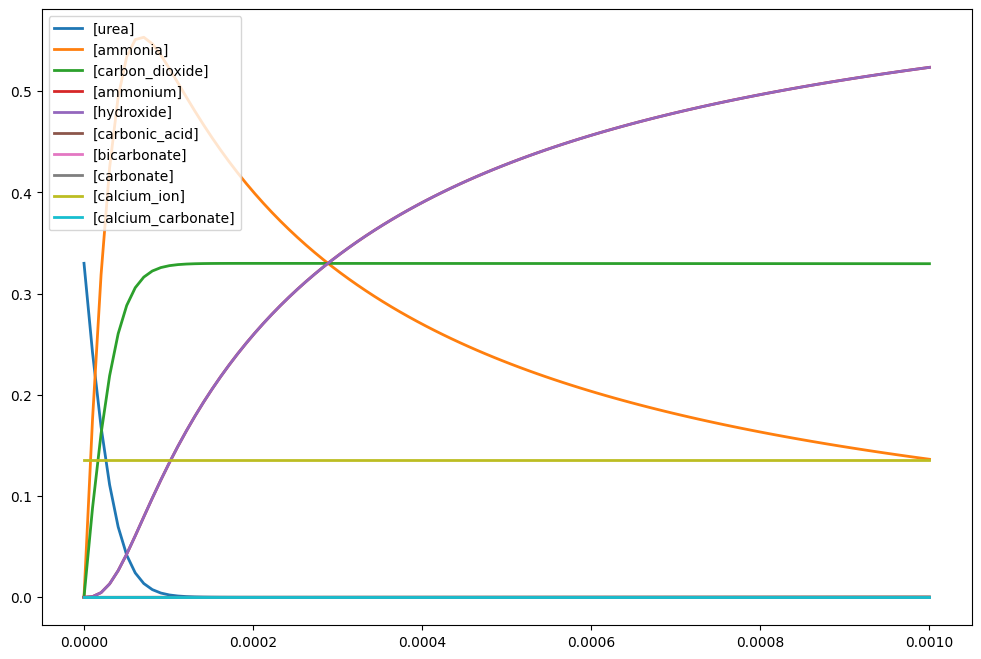

In [102]:
# rr_model = te.loada(antimony_fname)

# print(rr_model.getFloatingSpeciesIds())
# print(rr_model.getGlobalParameterIds())
# selections = list(rr_model.getFloatingSpeciesIds()) + list(rr_model.getGlobalParameterIds())

#rr_results = rr_model.simulate(0,100,100, selections=selections)
rr_results = rr_model.simulate(0,0.001,100)
rr_model.plot(figsize=(12,8))
rr_model.resetToOrigin()

### update SBML model species names, initial concentatrations

In [111]:
import math

corrected_sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model_corrected.xml'

d = libsbml.readSBMLFromFile(sbml_file)
m = d.getModel()
# for initial in m.getListOfInitialAssignments():
#     print(initial)

for species in m.getListOfSpecies():
    species.name = species.id
    #print(species.name, species.initial_concentration)
    if math.isnan(species.initial_concentration):
        species.initial_concentration = species.initial_amount
    else:
        print(species.name, species.initial_concentration)
    species.has_only_substance_units = False
    print(species)

libsbml.writeSBMLToFile(d,corrected_sbml_file)

water 55.0
<Species water "water">
<Species urea "urea">
<Species ammonia "ammonia">
<Species carbon_dioxide "carbon_dioxide">
<Species ammonium "ammonium">
<Species hydroxide "hydroxide">
<Species carbonic_acid "carbonic_acid">
<Species bicarbonate "bicarbonate">
<Species carbonate "carbonate">
<Species calcium_ion "calcium_ion">
<Species calcium_carbonate "calcium_carbonate">


1

### load corrected model as MIRA model and add priors

In [104]:
mira_model = template_model_from_sbml_file(corrected_sbml_file)

mira_model.initials



{'water': Initial(concept=Concept(name='water', display_name='water', description=None, identifiers={}, context={}, units=None), expression=55.0),
 'urea': Initial(concept=Concept(name='urea', display_name='urea', description=None, identifiers={}, context={}, units=None), expression=0.33),
 'ammonia': Initial(concept=Concept(name='ammonia', display_name='ammonia', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'carbon_dioxide': Initial(concept=Concept(name='carbon_dioxide', display_name='carbon_dioxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'ammonium': Initial(concept=Concept(name='ammonium', display_name='ammonium', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'hydroxide': Initial(concept=Concept(name='hydroxide', display_name='hydroxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-7),
 'carbonic_acid': Initial(concept=Concept(name='carbonic_ac

In [105]:
## for priors use uniform(0,1)

from mira.metamodel import Distribution


rate_constant_dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 1e-3,"maximum": 1.0 }     
                     )

for name,parameter in mira_model.parameters.items():
    if name.startswith('k'): # only assign priors for rate constants
        parameter.distribution = rate_constant_dist
    print(name, parameter, parameter.distribution)


V_max_urease name='V_max_urease' display_name=None description='' identifiers={} context={} units=None value=18000.0 distribution=None None
K_m_urease name='K_m_urease' display_name=None description='' identifiers={} context={} units=None value=0.3 distribution=None None
k2f name='k2f' display_name=None description='' identifiers={} context={} units=None value=1.0 distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0}) type='Uniform1' parameters={'minimum': 0.001, 'maximum': 1.0}
k2r name='k2r' display_name=None description='' identifiers={} context={} units=None value=1.0 distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0}) type='Uniform1' parameters={'minimum': 0.001, 'maximum': 1.0}
K_cat_CA name='K_cat_CA' display_name=None description='' identifiers={} context={} units=None value=530000.0 distribution=None None
CA_conc name='CA_conc' display_name=None description='' identifiers={} context={} units=None value=3e

In [106]:
mira_model.initials

{'water': Initial(concept=Concept(name='water', display_name='water', description=None, identifiers={}, context={}, units=None), expression=55.0),
 'urea': Initial(concept=Concept(name='urea', display_name='urea', description=None, identifiers={}, context={}, units=None), expression=0.33),
 'ammonia': Initial(concept=Concept(name='ammonia', display_name='ammonia', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'carbon_dioxide': Initial(concept=Concept(name='carbon_dioxide', display_name='carbon_dioxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'ammonium': Initial(concept=Concept(name='ammonium', display_name='ammonium', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'hydroxide': Initial(concept=Concept(name='hydroxide', display_name='hydroxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-7),
 'carbonic_acid': Initial(concept=Concept(name='carbonic_ac

In [107]:
mira_model.parameters

{'V_max_urease': Parameter(name='V_max_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=18000.0, distribution=None),
 'K_m_urease': Parameter(name='K_m_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=0.3, distribution=None),
 'k2f': Parameter(name='k2f', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0})),
 'k2r': Parameter(name='k2r', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0})),
 'K_cat_CA': Parameter(name='K_cat_CA', display_name=None, description='', identifiers={}, context={}, units=None, value=530000.0, distribution=None),
 'CA_conc': Parameter(name='CA_conc', display_name=None, description='', identifiers={}, context={}, units=None, value=3e-05,

In [108]:
# start_time = 0.0
# end_time = 10.0
# logging_step_size = 1
# num_samples = 10

# petrinet_results = pyciemss.sample(mira_model, end_time, logging_step_size, num_samples, start_time=start_time)

### create petri net model

In [109]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model

model_json_file_name = 'microbial_induced_calcium_carbonate_precipitation_petri_net_model.json'
 
petrinet_model = AMRPetriNetModel(Model(mira_model))


petrinet_model.to_json_file(
            model_json_file_name,
            name='microbial_induced_calcium_carbonate_precipitation_petri_net_model',
            description="microbial_induced_calcium_carbonate_precipitation_petri_net_model",
            indent=2,
        )



### simulate petri net model

In [110]:
start_time = 0.0
end_time = 1.0
logging_step_size = 0.01
num_samples = 10

petrinet_results = pyciemss.sample(model_json_file_name, end_time, logging_step_size, num_samples, start_time=start_time)
display(petrinet_results['data'].head())
print(petrinet_results.keys())


ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

ValueError: The model initial state could not be evaluated. Please check the model definition. This could be due to to a missing state variable or parameter, or an error in the initial state definition.
      Trace Shapes:  
       Param Sites:  
      Sample Sites:  
persistent_k2f dist |
              value |
persistent_k2r dist |
              value |
persistent_k4f dist |
              value |
persistent_k4r dist |
              value |
persistent_k5f dist |
              value |
persistent_k5r dist |
              value |
persistent_k6f dist |
              value |
persistent_k6r dist |
              value |

Setup